<a href="https://colab.research.google.com/github/Divyaanshvats/FIDROX_ASSIGNMENTS/blob/main/FIDROX_ISOLATION_FOREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AccessAI: Detecting Anomalous Swipe Behavior in Physical Access Control Systems(ML)**

# **IMPORT ALL THE REQUIRE LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import os
np.random.seed(42)
random.seed(42)
NUM_DAYS = 30
SWIPES_PER_DAY = 1000
TOTAL_RECORDS = NUM_DAYS * SWIPES_PER_DAY
user_ids = [f"U{str(i).zfill(3)}" for i in range(1, 101)]
doors = {
    "D01": "Main Entrance",
    "D02": "East Wing",
    "D03": "Server Room",# restricted
    "D04": "HR Department",
    "D05": "Rooftop Access",# rarely used
    "D06": "Finance Room",
    "D07": "Cafeteria",
    "D08": "Basement Storage",# rarely used
}

# **RANDOM GENERATION OF DATASET(SAME AS DBSCAN)**

In [2]:
data = []
start_date = datetime(2025, 5, 1)
for i in range(TOTAL_RECORDS):
    current_date = start_date + timedelta(days=i // SWIPES_PER_DAY)
    if np.random.rand() < 0.8:
        hour = np.random.randint(8, 19)
    else:
        hour = np.random.choice([0, 1, 2, 3, 4, 22, 23])

    minute = np.random.randint(0, 60)
    second = np.random.randint(0, 60)
    timestamp = current_date.replace(hour=hour, minute=minute, second=second)
    user = random.choice(user_ids)
    door = random.choices(list(doors.keys()), weights=[25, 20, 5, 15, 2, 10, 20, 3])[0]
    direction = random.choice(["IN", "OUT"])
    result = "Success" if np.random.rand() > 0.05 else "Failed"
    if np.random.rand() < 0.01:
        for _ in range(5):
            anomaly_timestamp = timestamp + timedelta(seconds=random.randint(1, 30))
            data.append([anomaly_timestamp, user, door, doors[door], direction, "Failed"])

    data.append([timestamp, user, door, doors[door], direction, result])
df = pd.DataFrame(data, columns=["Timestamp", "UserID", "DoorID", "DoorName", "Direction", "Result"])
df.head()

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed
4,2025-05-01 10:43:54,U012,D01,Main Entrance,IN,Success


In [3]:
output_path = "/mnt/data/AccessAI_Simulated_Swipe_Logs.csv"
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df.to_csv(output_path, index=False)
output_path

'/mnt/data/AccessAI_Simulated_Swipe_Logs.csv'

In [4]:
df = pd.read_csv("/mnt/data/AccessAI_Simulated_Swipe_Logs.csv")
df.head(3)

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success


In [5]:
len(df)#length of dataset

31505

In [6]:
# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['IsFailed'] = (df['Result'] == 'Failed').astype(int)
df['IsOddHour'] = df['Hour'].apply(lambda x: 1 if x < 6 or x > 21 else 0)
df['IsRestrictedDoor'] = df['DoorName'].isin(['Server Room', 'Rooftop Access', 'Basement Storage']).astype(int)
df['DirectionEncoded'] = (df['Direction'] == 'IN').astype(int)

In [7]:
from sklearn.ensemble import IsolationForest

# Select features
features_iforest = df[['Hour', 'IsFailed', 'IsOddHour', 'IsRestrictedDoor', 'DirectionEncoded']]

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(features_iforest)
df['is_anomaly'] = (df['anomaly_score'] == -1).astype(int)

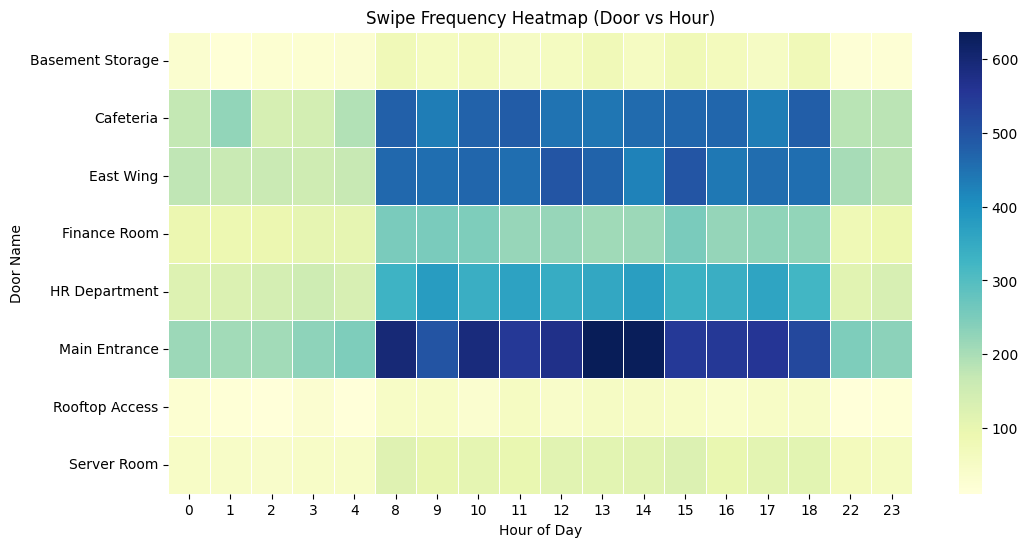

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table: count of swipes by Hour and DoorName
heatmap_data = df.pivot_table(index='DoorName', columns='Hour', values='UserID', aggfunc='count', fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Swipe Frequency Heatmap (Door vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Door Name')
plt.show()

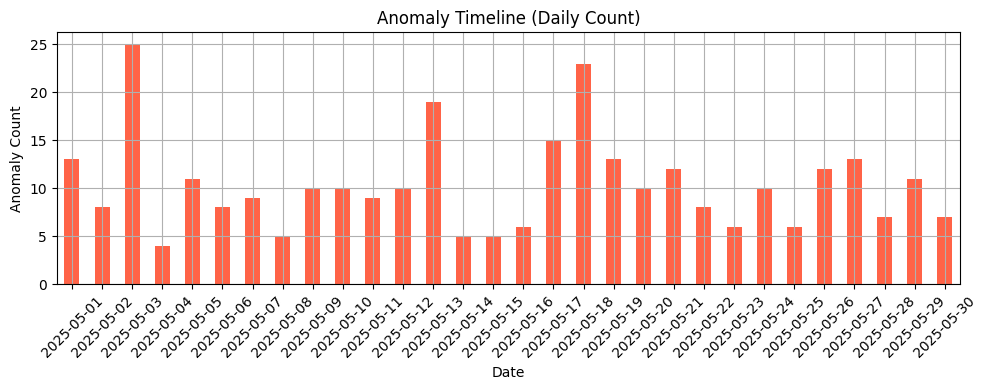

In [9]:
df['Date'] = df['Timestamp'].dt.date
daily_anomalies = df[df['is_anomaly'] == 1].groupby('Date').size()

plt.figure(figsize=(10, 4))
daily_anomalies.plot(kind='bar', color='tomato')
plt.title('Anomaly Timeline (Daily Count)')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

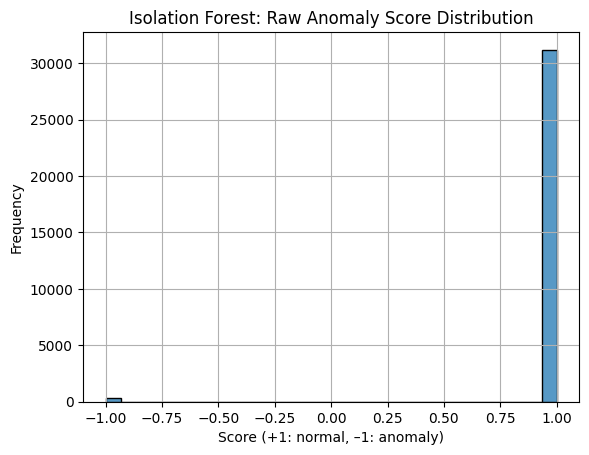

In [10]:
sns.histplot(df['anomaly_score'], bins=30, kde=False)
plt.title('Isolation Forest: Raw Anomaly Score Distribution')
plt.xlabel('Score (+1: normal, –1: anomaly)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: xlabel='anomaly_score', ylabel='Count'>

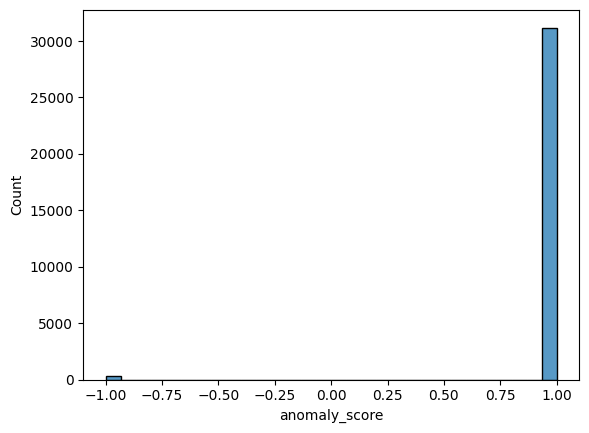

In [11]:
sns.histplot(df['anomaly_score'], bins=30, kde=False)

In [12]:
df['anomaly_raw_score'] = iso_forest.decision_function(features_iforest)
df['anomaly_raw_score'][:5]


,anomaly_raw_score
0,0.213159
1,0.256825
2,0.256825
3,0.085865
4,0.263637


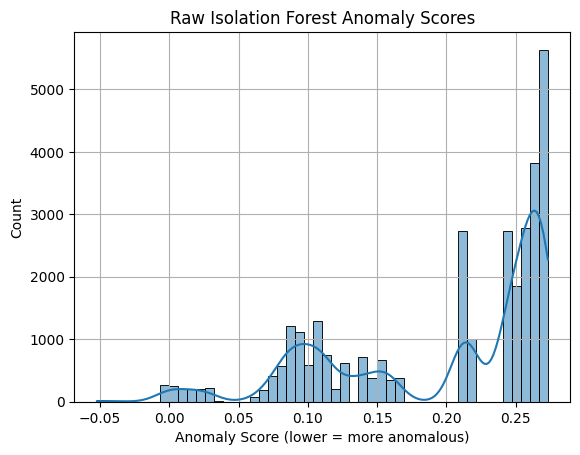

In [13]:
# Histogram of raw scores
sns.histplot(df['anomaly_raw_score'], bins=50, kde=True)
plt.title('Raw Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score (lower = more anomalous)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [14]:
sum(df['anomaly_raw_score']<0)

310

# **Let us consider anything below 0.05 as Anomally**

In [15]:
sum(df['anomaly_raw_score']<0.05)

1406

In [16]:
threshold = 0.05
df['custom_is_anomaly'] = (df['anomaly_raw_score'] < threshold).astype(int)
print("Number of custom anomalies:", df['custom_is_anomaly'].sum())

Number of custom anomalies: 1406


In [17]:
df[df['custom_is_anomaly'] == 0].sort_values('anomaly_raw_score').head(40000)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsFailed,IsOddHour,IsRestrictedDoor,DirectionEncoded,anomaly_score,is_anomaly,Date,anomaly_raw_score,custom_is_anomaly
26182,2025-05-25 18:37:29,U091,D06,Finance Room,OUT,Failed,18,1,0,0,0,1,0,2025-05-25,0.060765,0
9284,2025-05-09 18:38:52,U056,D02,East Wing,OUT,Failed,18,1,0,0,0,1,0,2025-05-09,0.060765,0
15851,2025-05-16 18:16:00,U082,D02,East Wing,OUT,Failed,18,1,0,0,0,1,0,2025-05-16,0.060765,0
20234,2025-05-20 18:26:47,U070,D02,East Wing,OUT,Failed,18,1,0,0,0,1,0,2025-05-20,0.060765,0
3353,2025-05-04 18:34:16,U046,D07,Cafeteria,OUT,Failed,18,1,0,0,0,1,0,2025-05-04,0.060765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,2025-05-30 12:08:23,U035,D02,East Wing,IN,Success,12,0,0,0,1,1,0,2025-05-30,0.273331,0
31502,2025-05-30 12:32:25,U074,D06,Finance Room,IN,Success,12,0,0,0,1,1,0,2025-05-30,0.273331,0
14588,2025-05-14 12:23:52,U004,D07,Cafeteria,IN,Success,12,0,0,0,1,1,0,2025-05-14,0.273331,0
44,2025-05-01 12:47:19,U020,D02,East Wing,IN,Success,12,0,0,0,1,1,0,2025-05-01,0.273331,0


In [18]:
df[df['custom_is_anomaly'] == 1].sort_values('anomaly_raw_score').tail(1500)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsFailed,IsOddHour,IsRestrictedDoor,DirectionEncoded,anomaly_score,is_anomaly,Date,anomaly_raw_score,custom_is_anomaly
7132,2025-05-07 23:57:15,U021,D05,Rooftop Access,IN,Failed,23,1,1,1,1,-1,1,2025-05-07,-0.052298,1
10507,2025-05-10 00:35:48,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1
10506,2025-05-10 00:35:39,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1
10505,2025-05-10 00:36:06,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1
10504,2025-05-10 00:36:02,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8696,2025-05-09 14:01:33,U098,D03,Server Room,IN,Failed,14,1,0,1,1,1,0,2025-05-09,0.033576,1
12364,2025-05-12 14:09:39,U043,D03,Server Room,IN,Failed,14,1,0,1,1,1,0,2025-05-12,0.033576,1
3372,2025-05-04 14:12:53,U055,D03,Server Room,IN,Failed,14,1,0,1,1,1,0,2025-05-04,0.033576,1
30353,2025-05-29 14:42:28,U088,D05,Rooftop Access,IN,Failed,14,1,0,1,1,1,0,2025-05-29,0.033576,1


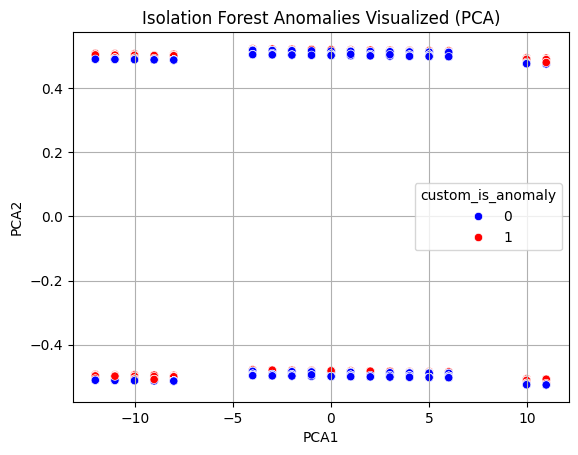

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_iforest)
df['PCA1'], df['PCA2'] = pca_result[:, 0], pca_result[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='custom_is_anomaly', palette=['blue', 'red'])
plt.title('Isolation Forest Anomalies Visualized (PCA)')
plt.grid(True)
plt.show()

In [20]:
df[df['custom_is_anomaly'] == 1].sort_values('anomaly_raw_score').head(10)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsFailed,IsOddHour,IsRestrictedDoor,DirectionEncoded,anomaly_score,is_anomaly,Date,anomaly_raw_score,custom_is_anomaly,PCA1,PCA2
7132,2025-05-07 23:57:15,U021,D05,Rooftop Access,IN,Failed,23,1,1,1,1,-1,1,2025-05-07,-0.052298,1,10.980259,0.492400
10507,2025-05-10 00:35:48,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1,-12.011620,-0.492770
10506,2025-05-10 00:35:39,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1,-12.011620,-0.492770
10505,2025-05-10 00:36:06,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1,-12.011620,-0.492770
10504,2025-05-10 00:36:02,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1,-12.011620,-0.492770
16502,2025-05-16 00:14:45,U011,D08,Basement Storage,OUT,Failed,0,1,1,1,0,-1,1,2025-05-16,-0.050036,1,-12.011620,-0.492770
19712,2025-05-19 00:13:25,U063,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-19,-0.050036,1,-12.011620,-0.492770
10508,2025-05-10 00:35:44,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.050036,1,-12.011620,-0.492770
7092,2025-05-07 22:57:46,U040,D03,Server Room,IN,Failed,22,1,1,1,1,-1,1,2025-05-07,-0.049629,1,9.980617,0.493033
6358,2025-05-07 22:45:01,U041,D03,Server Room,IN,Failed,22,1,1,1,1,-1,1,2025-05-07,-0.049629,1,9.980617,0.493033


In [22]:
# Z-score based anomaly detection
df['Z_Hour'] = np.abs((df['Hour'] - df['Hour'].mean()) / df['Hour'].std())
df['Z_Failed'] = np.abs((df['IsFailed'] - df['IsFailed'].mean()) / df['IsFailed'].std())

# Create anomaly column if z > 3
df['Anomaly_Z'] = ((df['Z_Hour'] > 3) | (df['Z_Failed'] > 3)).astype(int)

In [23]:
(df['Anomaly_Z'] == 1).astype(int)

,Anomaly_Z
0,0
1,0
2,0
3,1
4,0
...,...
31500,0
31501,0
31502,0
31503,0


In [24]:
df['Consensus'] = ((df['custom_is_anomaly'] == 1) & (df['Anomaly_Z'] == 1)).astype(int)
print("Anomalies agreed by both:", df['Consensus'].sum())

Anomalies agreed by both: 797
